<a href="https://colab.research.google.com/github/nourwalid70/Augmented-reality-and-image-mosaics/blob/main/Lab_2_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install sk-video

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from math import ceil
from skimage.transform import ProjectiveTransform
import random
import skvideo.io

# Part1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def loadVid(path):
	# Create a VideoCapture object and read from input file
	# If the input is the camera, pass 0 instead of the video file name
	cap = cv2.VideoCapture(path)
	 
	# Check if camera opened successfully
	if (cap.isOpened()== False): 
		print("Error opening video stream or file")

	i = 0
	# Read until video is completed
	while(cap.isOpened()):
		# Capture frame-by-frame
		i += 1
		ret, frame = cap.read()
		if ret == True:

			#Store the resulting frame
			if i == 1:
				frames = frame[np.newaxis, ...]
			else:
				frame = frame[np.newaxis, ...]
				frames = np.vstack([frames, frame])
				frames = np.squeeze(frames)
			
		else: 
			break
	 
	# When everything done, release the video capture object
	cap.release()

	return frames

In [ ]:
book_path = '/content/drive/MyDrive/Colab Notebooks/CV lab 2/Material/book.mov'
panda_path = '/content/drive/MyDrive/Colab Notebooks/CV lab 2/Material/ar_source.mov'
book_cover = cv2.imread('/content/drive/MyDrive/Colab Notebooks/CV lab 2/Material/cv_cover.jpg')  # book cover image
book_frames = loadVid(book_path)  # list of frames of the book video
panda_frames = loadVid(panda_path)  # list of frames of the book video

## Getting Correspondences

In [ ]:
def get_image_key_points():
  '''
    Applies SIFT detector for book cover image.
    returns:
      kp_cover: list of key points of book_cover
      des_cover: list of descriptors of key points of book_cover
  '''
  sift = cv2.SIFT_create()
  kp_cover, des_cover = sift.detectAndCompute(book_cover, None)
  return kp_cover, des_cover

In [ ]:
def get_correspondences(book_frame, des_cover):
  '''
    Gets 50 correspondences between book_cover and a single book frame.
    params:
      book_frame: a frame from the book video
      des_cover: list of descriptors of book_cover
    returns:
      good: list of DMatch objects of the best 50 correspondences
      kp_frame: list of key points of book_frame
      des_frame: list of descriptors of key points of book_frame
  '''
  sift = cv2.SIFT_create()
  kp_frame, des_frame = sift.detectAndCompute(book_frame, None)
  # BFMatcher with default params
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(des_cover,des_frame,k=2)

  # Apply ratio test
  good = []
  for m,n in matches:
      if m.distance < 0.75 * n.distance:
          good.append([m])

  # sort acsendingly by the matching distance and take top 50 correspondences
  good = sorted(good, key=lambda x: x[0].distance)[:50]
  return good, kp_frame, des_frame

In [ ]:
def draw_matches(book_cover, kp_cover, book_frame, kp_frame, good):
  '''
    Plots the matches between book_cover and book_frames.
    params:
      book_cover: book cover image
      kp_cover: list of keypoints of book_cover
      book_frame: a frame from the book video
      kp_frame: list of keypoints of book_frame
      good: list of DMatch objects of the best 50 correspondences
  '''
  # cv.drawMatchesKnn expects list of lists as matches.
  img = cv2.drawMatchesKnn(book_cover, kp_cover, book_frame, kp_frame, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  plt.imshow(img)

## Compute the Homography Parameters

In [ ]:
def get_correspondences_points(good, kp_cover, kp_frame):
  '''
    Gets the coordinates of matching pairs from book_cover and book_frame.
    params: 
      good: list of DMatch objects of the best 50 correspondences
      kp_cover: list of keypoints of book_cover
      kp_frame: list of keypoints of book_frame
    returns:
      pts_src: list of points from the source image (book_cover)
      pts_dst: list of points from the destination image (book_frame)
  '''
  pts_src, pts_dst = [], []
  for g in good:
    pts_src.append(list(kp_cover[g[0].queryIdx].pt))
    pts_dst.append(list(kp_frame[g[0].trainIdx].pt))

  pts_src = np.array(pts_src)
  pts_dst = np.array(pts_dst)
  return pts_src, pts_dst

In [ ]:
def calc_homography(pts_src, pts_dst):
  '''
    Calculates the homography matrix from the set of input matching points.
    params: 
      pts_src: list of points from the source image (book_cover)
      pts_dst: list of points from the destination image (book_frame)
    returns:
      h: a 3x3 homography matrix
  '''

  n = len(pts_src)

  x = pts_src[:, 0]
  y = pts_src[:, 1]
  x_ = pts_dst[:, 0]
  y_ = pts_dst[:, 1]

  A = np.zeros((2*n, 9))

  A[::2, 0] = -1*x
  A[::2, 1] = -1*y
  A[::2, 2] = -1
  A[::2, 3:6] = 0
  A[::2, 6] = x * x_
  A[::2, 7] = y * x_
  A[::2, 8] = x_
  
  A[1::2, 0:3] = 0
  A[1::2, 3] = -1 * x
  A[1::2, 4] = -1 * y
  A[1::2, 5] = -1
  A[1::2, 6] = x * y_
  A[1::2, 7] = y * y_
  A[1::2, 8] = y_

  _, _, VT = np.linalg.svd(A)  # sigma is sorted descendingly
  v_i = VT[-1]  # the column corresponding to the smallest singlur value
  h = v_i.reshape(3, 3)
  h = h / h[-1, -1]

  return h

In [ ]:
def ransac(calc_homography, pts_src, pts_dst):

  '''
    Applies RANSAC algorithm on the set of input matching points.
    params: 
      calc_homography: a function that calculates the homography matrix
      pts_src: list of points from the source image (book_cover)
      pts_dst: list of points from the destination image (book_frame)
    returns:
      best_pts_src: set of inliers from pts_src
      best_pts_dst: set of inliers from pts_dst
  '''

  point_count = len(pts_src)
  pts_src, pts_dst = np.array(pts_src), np.array(pts_dst)

  ones = np.ones([point_count, 1])
  pts_src = np.append(pts_src, ones, axis=1)
  pts_dst = np.append(pts_dst, ones, axis=1)

  max_inliers = 0
  best_error = 0
  num_iter = 100
  tol = 5
  for i in range(num_iter):
      rand_matches = np.random.permutation(point_count)[:4]
      p1 = pts_src[rand_matches]
      p2 = pts_dst[rand_matches]
      H = calc_homography(p1, p2)  # model

      pts_src_transformed = (H @ pts_src.T).T
      pts_src_transformed = pts_src_transformed / pts_src_transformed[:, -1].reshape(-1, 1)
      
      error = (np.square((pts_src_transformed - pts_dst)).sum(axis=1) < tol).astype('int')
      inliers = error.sum()
      if inliers > max_inliers:
          max_inliers = inliers
          best_error = error

  best_pts_src = pts_src[np.where(best_error==True)][:, :-1]
  best_pts_dst = pts_dst[np.where(best_error==True)][:, :-1]

  return best_pts_src, best_pts_dst

## Calculate Book Coordinates

In [ ]:
def get_book_cover_corners():
  '''
    Returns the 4 corners of book_cover in homogeneous coordinates. 
  '''
  height, width = book_cover.shape[0], book_cover.shape[1]
  # p1   p2

  # p4   p3

  #calc corners
  # p -> (y, x, 1)
  p1, p2, p3, p4 = [0, 0, 1], [width, 0, 1], [width, height, 1], [0, height, 1]
  return [p1, p2, p3, p4]

In [ ]:
def get_book_frame_corners(p, homography, book_frame):
  '''
    Gets the corners of the book in a single frame in the book video
    params:
      p: list of book corners in book_cover in homogeneous coordinates
      homography: a 3x3 homography matrix
      book_frame: a frame from the book video
    returns:
      list of corner points of the book frame in heterogeneous coordinates
  '''
  # p >> list of corner points
  q1, q2, q3, q4 = homography @ p[0], homography @ p[1], homography @ p[2], homography @ p[3]

  # normalize points
  q1 /= q1[-1]
  q2 /= q2[-1]
  q3 /= q3[-1]
  q4 /= q4[-1]

  # transform into heterogeneous coordinates
  q1 = q1[:-1]
  q2 = q2[:-1]
  q3 = q3[:-1]
  q4 = q4[:-1]

  # insure images aren't ourside the frame coordinates
  q1[0], q1[1] = max(q1[0], 0), max(q1[1], 0)
  q2[0], q2[1] = min(q2[0], book_frame.shape[1]), max(q2[1], 0)
  q3[0], q3[1] = min(q3[0], book_frame.shape[1]), min(q3[1], book_frame.shape[0])
  q4[0], q4[1] = max(q4[0], 0), min(q4[1], book_frame.shape[0])

  # round to integers
  q1 = [round(x) for x in q1]
  q2 = [round(x) for x in q2]
  q3 = [round(x) for x in q3]
  q4 = [round(x) for x in q4]

  
  return [q1, q2, q3, q4]

In [ ]:
def calc_panda_center(panda_frame):
  '''
    Returns the center coordinates of a panda frame
  '''
  # centers -> (x, y)
  panda_center = int(panda_frame.shape[1]/2), int(panda_frame.shape[0]/2)
  return panda_center

In [ ]:
def calc_book_center(q):
  '''
    Calculates the center coordinates of the book in a book frame by averaging its corners
  '''
  book_center = int((q[0][0] + q[1][0] + q[2][0] + q[3][0])/4), int((q[0][1] + q[1][1] + q[2][1] + q[3][1])/4)
  return book_center

In [ ]:
def calc_panda_frame_corners(panda_center, book_center, q): 
  '''
    Calculates the projected book corners coordinates in panda_frame
    params: 
      panda_center: center of the panda frame
      book_center: center of the book frame
      q: corners coordinates in the book frame
  '''
  # wi -> (x, y)
  w1 = panda_center[0] - book_center[0] + q[0][0], panda_center[1] - book_center[1] + q[0][1], 
  w2 = panda_center[0] - book_center[0] + q[1][0], panda_center[1] + q[1][1] - book_center[1]
  w3 = panda_center[0] + q[2][0] - book_center[0], panda_center[1] + q[2][1] - book_center[1]
  w4 = panda_center[0] + q[3][0] - book_center[0], panda_center[1] - book_center[1] + q[3][1]
  return [w1, w2, w3, w4]

### Drawing Corner Points

In [ ]:
def draw_book_corners(book_frame, q, book_center=None):
  '''
    Draws corners on book_frame image
  '''
  image = cv2.circle(book_frame, q[0], radius=10, color=(0, 0, 255), thickness=-1)  # blue
  image = cv2.circle(image, q[1], radius=10, color=(0, 255, 0), thickness=-1)       # green
  image = cv2.circle(image, q[2], radius=10, color=(255, 0, 0), thickness=-1)       # red
  image = cv2.circle(image, q[3], radius=10, color=(255, 255, 255), thickness=-1)   # white
  if(book_center):
    image = cv2.circle(image, book_center, radius=10, color=(0, 0, 0), thickness=-1)  # black
  plt.imshow(image)

In [ ]:
def draw_panda_corners(panda_frame, w, panda_center=None):
  '''
    Draws corners on panda_frame image
  '''
  image = cv2.circle(panda_frame, w[0], radius=10, color=(0, 0, 255), thickness=-1)   # blue
  image = cv2.circle(image, w[1], radius=10, color=(0, 255, 0), thickness=-1)         # green
  image = cv2.circle(image, w[2], radius=10, color=(255, 0, 0), thickness=-1)         # red
  image = cv2.circle(image, w[3], radius=10, color=(255, 255, 255), thickness=-1)     # white
  if(panda_center):
    image = cv2.circle(image, panda_center, radius=10, color=(0, 0, 0), thickness=-1)   # black

  plt.imshow(image)

## Crop AR Video Frames

In [ ]:
def add_padding(panda_frame, w, panda_center):

  '''
    Adds black padding to an image if panda_frame is too small to fit in the book crop
    params: 
      panda_frame: a frame from the panda video
      w: corner points in the panda frame
    returns the padded panda_frame and shifted corners coordinates
  '''

  d1, d2 = 0 - min(w[0][1], w[1][1]), max(w[2][1], w[3][1]) - panda_frame.shape[0]
  height = panda_frame.shape[0]
  if(d1 > 0):
    height += d1
  if(d2 > 0):
    height += d2

  new_frame = np.zeros((height, panda_frame.shape[1], panda_frame.shape[2]))
  if(d1 > 0):
    new_frame[d1 : d1 + panda_frame.shape[0], :, :] = panda_frame
    new_w = []
    new_w.append((w[0][0], w[0][1] + d1))
    new_w.append((w[1][0], w[1][1] + d1))
    new_w.append((w[2][0], w[2][1] + d1))
    new_w.append((w[3][0], w[3][1] + d1))
    new_center = (panda_center[0], panda_center[1] + d1)
    return new_frame, new_w, new_center

  return panda_frame, w, panda_center

In [ ]:
def get_panda_mask(panda_frame, w):
  '''
    Creates a mask array to crop panda_frame
    params: 
      panda_frame: a frame from the panda video
      w: corner points in the panda frame
    returns:
      mask: a numpy array of the same shape as panda_frame. represents a mask to extract the area bounded by points in w.
  '''
  # creating a mask for the panda frame
  mask = np.zeros(panda_frame.shape[:2], dtype="uint8")
  points = np.array([w[3], w[2], w[1], w[0]])
  mask = cv2.fillPoly(mask, np.int32([points]), 255)
  return mask

In [ ]:
def overlay_panda(book_frame, panda_frame, panda_mask, q, w):
  '''
    Overlays the panda_frame region masked by panda_mask on book_frame.
    params:
      book_frame: a frame from the book video
      panda_frame: a frame from the panda video
      panda_mask: a mask to extract the area bounded by points in w
      q: book corners in book_frame
      w: book corners in panda_frame
  '''
  q1, q2, q3, q4 = q
  w1, w2, w3, w4 = w

  # applying the book frame as background to the panda frame
  book_frame_cropped = book_frame[min(q1[1], q2[1], q3[1], q4[1]) : max(q1[1], q2[1], q3[1], q4[1]), min(q1[0], q2[0], q3[0], q4[0]) : max(q1[0], q2[0], q3[0], q4[0])]
  panda_frame_cropped = panda_frame[min(w1[1], w2[1], w3[1], w4[1]) : max(w1[1], w2[1], w3[1], w4[1]), min(w1[0], w2[0], w3[0], w4[0]) : max(w1[0], w2[0], w3[0], w4[0])]
  mask_cropped = panda_mask[min(w1[1], w2[1], w3[1], w4[1]) : max(w1[1], w2[1], w3[1], w4[1]), min(w1[0], w2[0], w3[0], w4[0]) : max(w1[0], w2[0], w3[0], w4[0])]
  
  diff_x, diff_y = book_frame_cropped.shape[0] - panda_frame_cropped.shape[0], book_frame_cropped.shape[1] - panda_frame_cropped.shape[1]
  if(diff_x > 0):
    book_frame_cropped = book_frame_cropped[:-diff_x, :]
  if(diff_y > 0):
    book_frame_cropped = book_frame_cropped[:, :-diff_y]

  # merging book_frame_cropped (background) and panda_frame_cropped (foreground)
  mask_inv = cv2.bitwise_not(mask_cropped)
  panda_masked = cv2.bitwise_and(panda_frame_cropped, panda_frame_cropped, mask=mask_cropped)
  book_masked = cv2.bitwise_and(book_frame_cropped, book_frame_cropped, mask=mask_inv)
  overlay = cv2.add(panda_masked.astype(np.uint8), book_masked.astype(np.uint8))

  book_frame[min(q1[1], q2[1], q3[1], q4[1]) : max(q1[1], q2[1], q3[1], q4[1])-diff_x, min(q1[0], q2[0], q3[0], q4[0]) : max(q1[0], q2[0], q3[0], q4[0])-diff_y] = overlay

  return book_frame_cropped, panda_frame_cropped, mask_cropped, panda_masked, book_masked, overlay

## Create a video

In [ ]:
output_path = '/content/drive/MyDrive/Colab Notebooks/CV lab 2/part1_output_video.mp4'
output_frames = []

kp_cover, des_cover = get_image_key_points()
p = get_book_cover_corners()
for i in range(min(len(panda_frames), len(book_frames))):
  print(f'frame #{i}')
  book_frame = cv2.cvtColor(book_frames[i], cv2.COLOR_BGR2RGB)
  panda_frame = cv2.cvtColor(panda_frames[i], cv2.COLOR_BGR2RGB)
  good, kp_frame, des_frame = get_correspondences(book_frame, des_cover)
  pts_src, pts_dst = get_correspondences_points(good, kp_cover, kp_frame)
  pts_src, pts_dst = ransac(calc_homography, pts_src, pts_dst) 
  h = calc_homography(pts_src, pts_dst) 
  q = get_book_frame_corners(p, h, book_frame)
  panda_center = calc_panda_center(panda_frame)
  book_center = calc_book_center(q)
  w = calc_panda_frame_corners(panda_center, book_center, q)

  panda_frame, w, panda_center = add_padding(panda_frame, w, panda_center) # updated panda_center
  panda_mask = get_panda_mask(panda_frame, w)

  overlay_panda(book_frame, panda_frame, panda_mask, q, w)

  output_frames.append(book_frame)

skvideo.io.vwrite(output_path, output_frames)

## Example Frame

In [ ]:
kp_cover, des_cover = get_image_key_points()
p = get_book_cover_corners()

i = 0 #437 # 8
book_frame = cv2.cvtColor(book_frames[i], cv2.COLOR_BGR2RGB)
panda_frame = cv2.cvtColor(panda_frames[i], cv2.COLOR_BGR2RGB)
good, kp_frame, des_frame = get_correspondences(book_frame, des_cover)
pts_src, pts_dst = get_correspondences_points(good, kp_cover, kp_frame)
pts_src, pts_dst = ransac(calc_homography, pts_src, pts_dst) 
h = calc_homography(pts_src, pts_dst) 
print(f'our h \n {h}')
homography, _ = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC, 5.0)
print(f'built in h \n {homography}')
q = get_book_frame_corners(p, h, book_frame)
panda_center = calc_panda_center(panda_frame)
book_center = calc_book_center(q)
w = calc_panda_frame_corners(panda_center, book_center, q)

our h 
 [[ 7.80624530e-01  4.02659532e-03  1.18746762e+02]
 [-4.78831466e-02  7.83163210e-01  7.67104213e+01]
 [-7.71855486e-05 -7.18956623e-05  1.00000000e+00]]
built in h 
 [[ 7.81371893e-01  4.27983929e-03  1.18670198e+02]
 [-4.74783850e-02  7.83730477e-01  7.66183930e+01]
 [-7.58309312e-05 -7.11475615e-05  1.00000000e+00]]


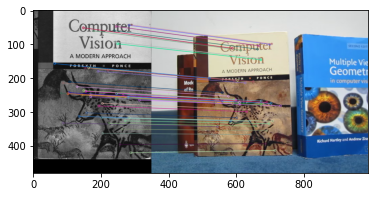

In [ ]:
draw_matches(book_cover, kp_cover, book_frame, kp_frame, good)

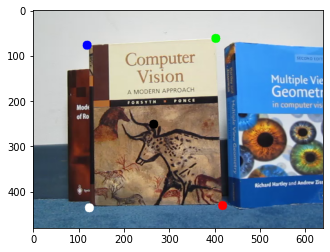

In [ ]:
draw_book_corners(book_frame, q, book_center)

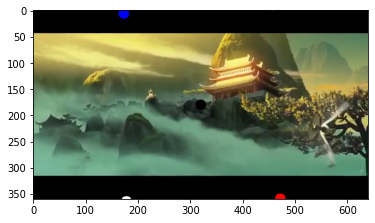

In [ ]:
draw_panda_corners(panda_frame, w, panda_center)

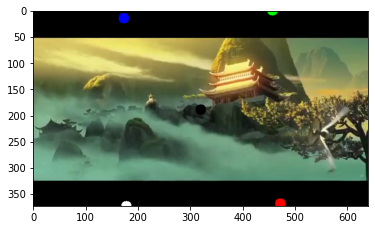

In [ ]:
panda_frame, w, panda_center = add_padding(panda_frame, w, panda_center)
draw_panda_corners(panda_frame.astype('uint8'), w, panda_center)

In [ ]:
panda_mask = get_panda_mask(panda_frame, w)
print('q = ', q)
print('w = ', w)
book_frame_cropped, panda_frame_cropped, mask_cropped, panda_masked, book_masked, overlay = overlay_panda(book_frame, panda_frame, panda_mask, q, w)

q =  [[119, 77], [403, 62], [418, 430], [124, 435]]
w =  [(173, 15), (457, 0), (472, 368), (178, 373)]


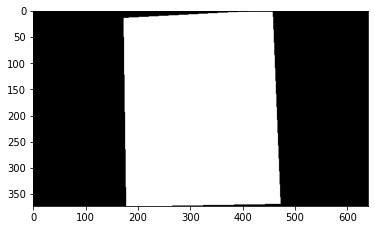

In [ ]:
plt.imshow(panda_mask, cmap='gray')

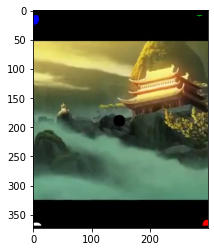

In [ ]:
plt.imshow(panda_frame_cropped.astype('uint8'))

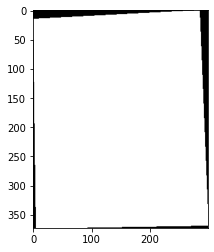

In [ ]:
plt.imshow(mask_cropped, cmap='gray')

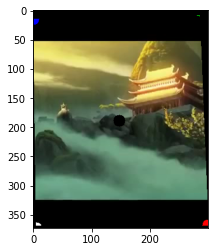

In [ ]:
plt.imshow(panda_masked.astype('uint8'))

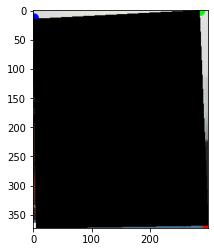

In [ ]:
plt.imshow(book_masked)

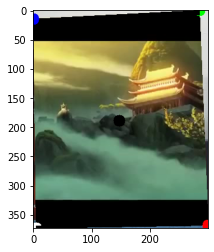

In [ ]:
plt.imshow(overlay)

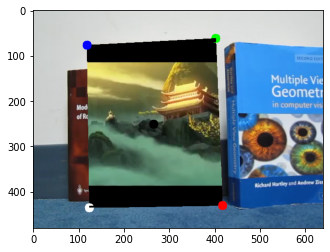

In [ ]:
plt.imshow(book_frame)